In [3]:
!pip install backtrader

     |████████████████████████████████| 419kB 2.6MB/s 


Starting Portfolio Value: 10000.00
2018-03-28 BUY CREATE, 40.28
2018-03-29 BUY EXECUTED, Price: 40.61, Cost: 4061.00, Comm 0.00
2018-04-04 SELL CREATE, 41.53
2018-04-05 SELL EXECUTED, Price: 41.76, Cost: 4061.00, Comm: 0.00
2018-04-05 OPERATION PROFIT, GROSS 115.00, NET 115.00
2018-04-18 BUY CREATE, 43.03
2018-04-19 BUY EXECUTED, Price: 42.05, Cost: 4205.00, Comm 0.00
2018-04-26 SELL CREATE, 39.74
2018-04-27 SELL EXECUTED, Price: 39.68, Cost: 4205.00, Comm: 0.00
2018-04-27 OPERATION PROFIT, GROSS -237.00, NET -237.00
2018-05-11 BUY CREATE, 45.81
2018-05-14 BUY EXECUTED, Price: 45.91, Cost: 4591.00, Comm 0.00
2018-10-29 SELL CREATE, 51.74
2018-10-30 SELL EXECUTED, Price: 51.47, Cost: 4591.00, Comm: 0.00
2018-10-30 OPERATION PROFIT, GROSS 556.00, NET 556.00
2019-02-12 BUY CREATE, 41.98
2019-02-13 BUY EXECUTED, Price: 42.10, Cost: 4210.00, Comm 0.00
2019-05-24 SELL CREATE, 44.14
2019-05-28 SELL EXECUTED, Price: 44.12, Cost: 4210.00, Comm: 0.00
2019-05-28 OPERATION PROFIT, GROSS 202.00, NE

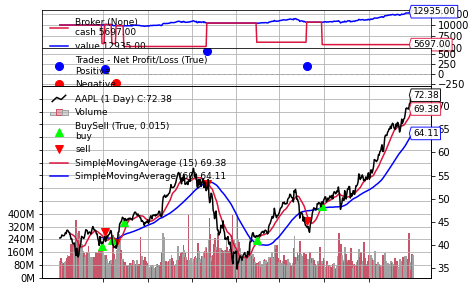

In [5]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import matplotlib.pyplot as plt
import backtrader as bt
import datetime

#Creating strategy
class TestStrategy(bt.Strategy):
    params = (
        ('smallmaperiod', 15),
        ('longmaperiod', 60)
    )

    def log(self, txt, dt = None):
        '''Printing function for the complete strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s %s' % (dt.isoformat(), txt))
    
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.volume = self.datas[0].volume

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        #Adding SMA indicator
        self.smallsma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period = self.params.smallmaperiod
        )
        self.longsma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period = self.params.longmaperiod
        )
        #Adding Volume SMA
        #bt.SimpleMovingAverage(self.data.volume)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm)
                )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm: %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
                self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return 

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def next(self):
        #self.log('Close, %.2f' % self.dataclose[0])

        if self.order:
            return

        #check if we are in market
        if not self.position:
            if self.smallsma[0] > self.longsma[0]:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                print(self.volume)

        else:
            if self.smallsma[0] < self.longsma[0]:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)
    cerebro.broker.setcash(10000.0)
    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    #Adding data feed
    data = bt.feeds.YahooFinanceData(
        dataname = 'AAPL', 
        fromdate = datetime.datetime(2018, 1, 1),
        todate = datetime.datetime(2019, 12, 31),
        reverse = False
    )
    cerebro.adddata(data)
    
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(iplot = False)